# Análise Exploratória dos Dados
---

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", 100)

BASE_DIR = Path("data_ons")

def find_latest_file(base_dir: Path, pattern: str, recursive: bool = False) -> Path:
    
    globber = base_dir.rglob if recursive else base_dir.glob
    matches = list(globber(pattern))
    if not matches:
        raise FileNotFoundError(f"Nenhum arquivo encontrado para o padrão: {pattern}")
    latest = max(matches, key=lambda p: p.stat().st_mtime)
    return latest

# Usar padrões com wildcard para lidar com sufixos de data
df_carga_v = pd.read_parquet(find_latest_file(BASE_DIR, "carga_verificada_SECO*.parquet"))
df_carga_p = pd.read_parquet(find_latest_file(BASE_DIR, "carga_programada_SECO*.parquet"))
df_balanco = pd.read_parquet(find_latest_file(BASE_DIR, "balanco_subsistemas*.parquet"))
df_cmo = pd.read_parquet(find_latest_file(BASE_DIR, "cmo_semi_horario_SECO*.parquet"))
df_gtm = pd.read_parquet(find_latest_file(BASE_DIR, "geracao_termica_motivo*.parquet"))

print("Arquivos carregados:")
print("df_carga_v:", find_latest_file(BASE_DIR, "carga_verificada_SECO*.parquet"))
print("df_carga_p:", find_latest_file(BASE_DIR, "carga_programada_SECO*.parquet"))
print("df_balanco:", find_latest_file(BASE_DIR, "balanco_subsistemas*.parquet"))
print("df_cmo:", find_latest_file(BASE_DIR, "cmo_semi_horario_SECO*.parquet"))
print("df_gtm:", find_latest_file(BASE_DIR, "geracao_termica_motivo*.parquet"))

Arquivos carregados:
df_carga_v: data_ons\carga_verificada_SECO_2023_2025.parquet
df_carga_p: data_ons\carga_programada_SECO_2023_2025.parquet
df_balanco: data_ons\balanco_subsistemas_2015_2025.parquet
df_cmo: data_ons\cmo_semi_horario_SECO_2020_2025.parquet
df_gtm: data_ons\geracao_termica_motivo_SECO_2023_2025.parquet


In [ ]:
def fix_datetime(df, col):
    df[col] = pd.to_datetime(df[col], utc=True, errors="coerce")
    df = df.dropna(subset=[col])
    df = df.sort_values(col)
    return df

df_carga_v = fix_datetime(df_carga_v, "din_referenciautc")
df_carga_p = fix_datetime(df_carga_p, "din_referenciautc")
df_balanco = fix_datetime(df_balanco, "din_instante")
df_cmo = fix_datetime(df_cmo, "din_instante") if "din_instante" in df_cmo.columns else fix_datetime(df_cmo, "din_referenciautc")
df_gtm = fix_datetime(df_gtm, "din_instante")

## Visão geral das bases
---

In [ ]:
dfs = {
    "Carga Verificada": df_carga_v,
    "Carga Programada": df_carga_p,
    "Balanço dos Subsistemas": df_balanco,
    "CMO": df_cmo,
    "Geração Térmica por Motivo de Despacho": df_gtm,
}

for name, df in dfs.items():
    print(f"Dataset: {name}")
    print(f"Shape do Dataframe: {df.shape}")
    print(f"Colunas:\n{df.columns.tolist()[:12]}" + ("..." if len(df.columns) > 12 else ""), end="\n\n")

## Estatísticas Descritivas das Variáveis Principais
---

In [ ]:
df_balanco.describe().T

In [ ]:
df_carga_v.describe().T

In [ ]:
df_cmo.describe().T

## Carga Verificada
---

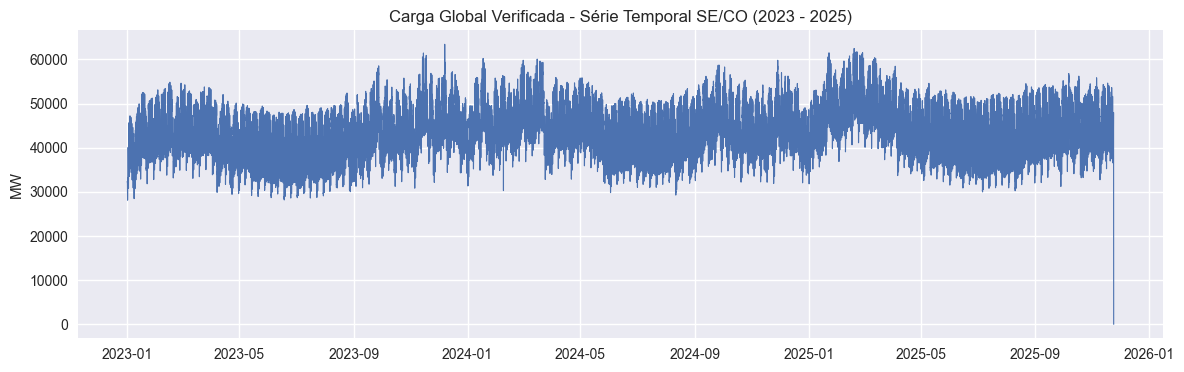

In [29]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df_carga_v["din_referenciautc"], df_carga_v["val_cargaglobal"], linewidth=0.8)
ax.set_title("Carga Global Verificada - Série Temporal SE/CO (2023 - 2025)")
ax.set_ylabel("MW")
plt.show()

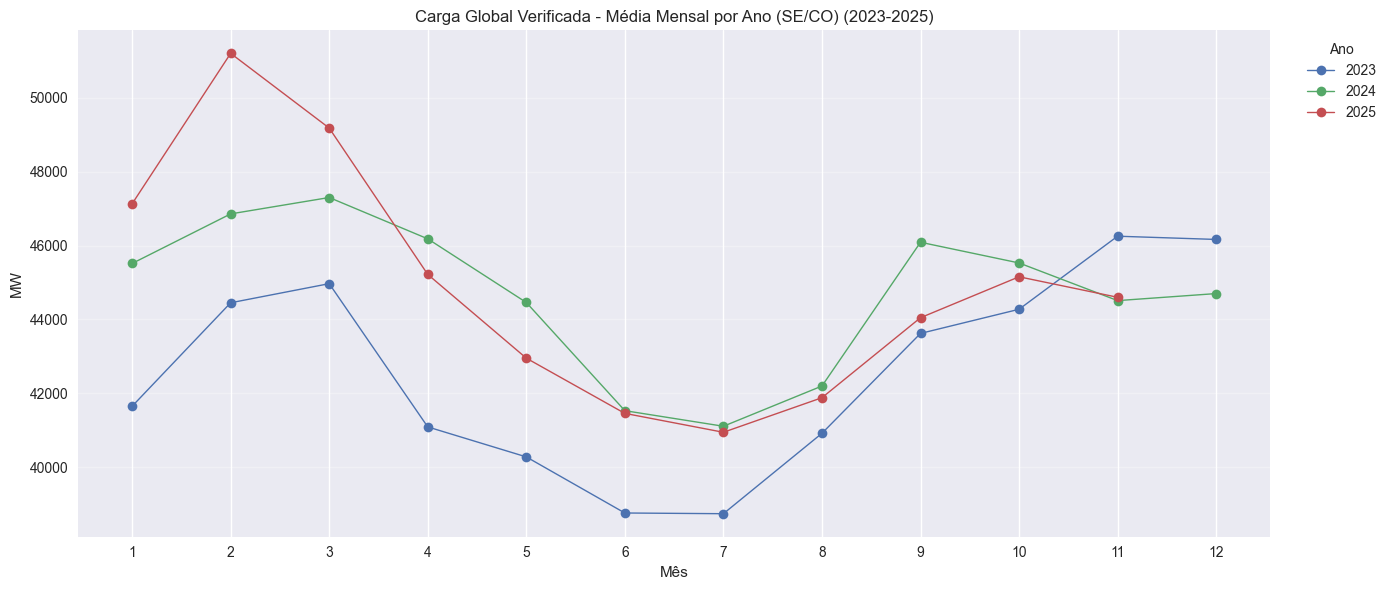

In [30]:
df = df_carga_v.copy()
df['year'] = df['din_referenciautc'].dt.year
df['month'] = df['din_referenciautc'].dt.month
df['val_cargaglobal'] = pd.to_numeric(df['val_cargaglobal'], errors='coerce')

pivot = df.groupby(['year', 'month'])['val_cargaglobal'].mean().unstack(level=0)

pivot = pivot.reindex(range(1, 13))

fig, ax = plt.subplots(figsize=(14, 6))
pivot.plot(ax=ax, marker='o', linewidth=1)

ax.set_xticks(range(1, 13))
ax.set_xlabel('Mês')
ax.set_ylabel('MW')
ax.set_title('Carga Global Verificada - Média Mensal por Ano (SE/CO) (2023-2025)')
ax.legend(title='Ano', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

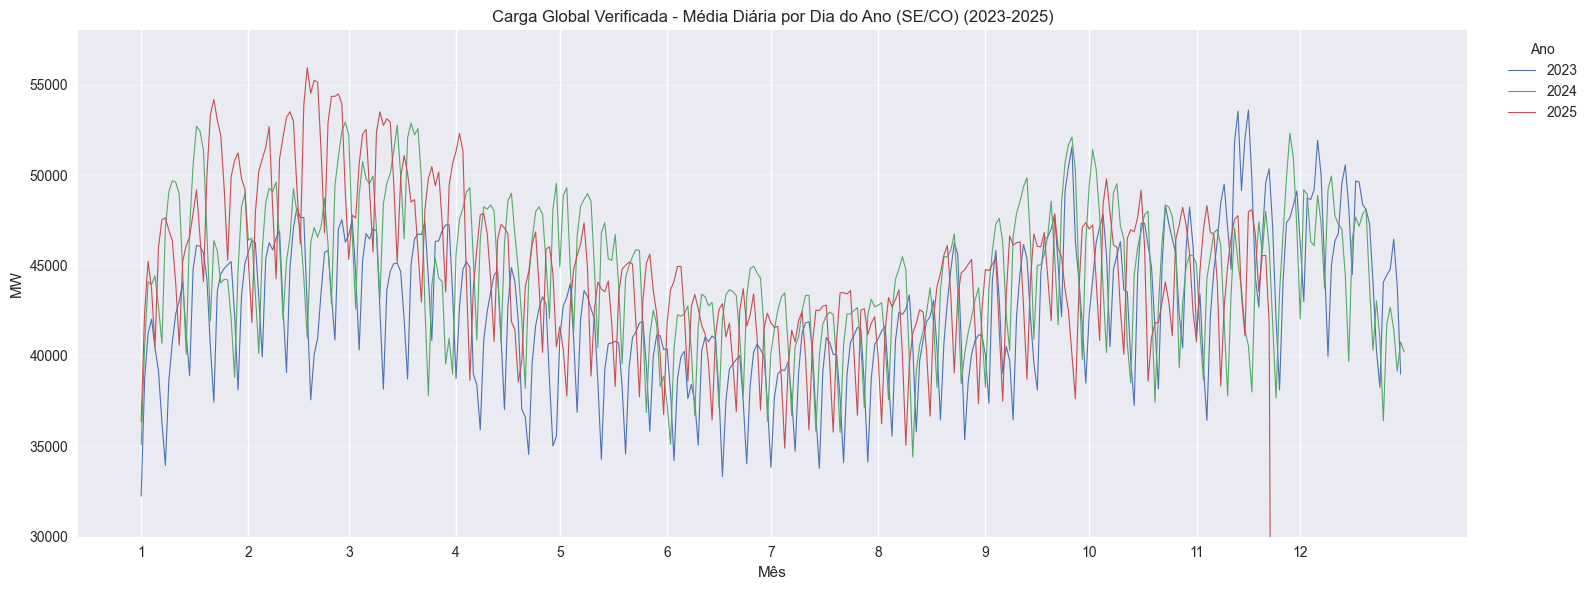

In [35]:
df = df_carga_v.copy()
df['year'] = df['din_referenciautc'].dt.year
df['doy'] = df['din_referenciautc'].dt.dayofyear
df['val_cargaglobal'] = pd.to_numeric(df['val_cargaglobal'], errors='coerce')

pivot = df.groupby(['year', 'doy'])['val_cargaglobal'].mean().unstack(level=0)
pivot = pivot.reindex(range(1, 367))

fig, ax = plt.subplots(figsize=(16, 6))
pivot.plot(ax=ax, linewidth=0.8)

first_of_month = pd.to_datetime([f'2020-{m:02d}-01' for m in range(1, 13)]).dayofyear  # 2020: ano bissexto
ax.set_xticks(first_of_month)
ax.set_xticklabels(range(1, 13))
ax.set_xlabel('Mês')
ax.set_ylabel('MW')
ax.set_title('Carga Global Verificada - Média Diária por Dia do Ano (SE/CO) (2023-2025)')
ax.set_ylim(30000, 58000)
ax.legend(title='Ano', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Algo diferenciado
---

In [41]:
df_carga_v

,cod_areacarga,din_atualizacao,dat_referencia,din_referenciautc,val_cargaglobal,val_cargaglobalcons,val_cargaglobalsmmgd,val_cargasupervisionada,val_carganaosupervisionada,val_cargammgd,val_consistencia
0,SECO,2023-05-04T08:52:52.979Z,2023-01-01,2023-01-01T03:30:00.000Z,32179.732,32179.732,32069.662,29086.734,2982.9272,110.07,0.0
1,SECO,2023-05-04T08:52:52.979Z,2023-01-01,2023-01-01T04:00:00.000Z,32388.713,32388.713,32278.684,29301.725,2976.9580,110.03,0.0
2,SECO,2023-05-04T08:52:52.979Z,2023-01-01,2023-01-01T04:30:00.000Z,32367.078,32367.078,32257.107,29285.260,2971.8477,109.97,0.0
3,SECO,2023-05-04T08:52:52.979Z,2023-01-01,2023-01-01T05:00:00.000Z,32221.596,32221.596,32111.465,29141.844,2969.6216,110.13,0.0
4,SECO,2023-05-04T08:52:52.979Z,2023-01-01,2023-01-01T05:30:00.000Z,31822.168,31822.168,31711.838,28743.684,2968.1543,110.33,0.0
...,...,...,...,...,...,...,...,...,...,...,...
50779,SECO,2025-11-23T23:31:27.995Z,2025-11-23,2025-11-24T01:00:00.000Z,0.000,0.000,0.000,0.000,2609.9778,110.11,0.0
50780,SECO,2025-11-23T23:31:27.995Z,2025-11-23,2025-11-24T01:30:00.000Z,0.000,0.000,0.000,0.000,2610.7427,110.11,0.0
50781,SECO,2025-11-23T23:31:27.995Z,2025-11-23,2025-11-24T02:00:00.000Z,0.000,0.000,0.000,0.000,2609.5696,110.11,0.0
50782,SECO,2025-11-23T23:31:27.995Z,2025-11-23,2025-11-24T02:30:00.000Z,0.000,0.000,0.000,0.000,2608.1772,110.11,0.0


In [43]:
df_carga = (
    df_carga_v[["din_referenciautc", "val_cargaglobalcons"]]
    .merge(
        df_carga_p[["din_referenciautc", "val_cargaglobalprogramada"]]
        .rename(columns={"val_cargaglobalprogramada": "val_carga_prog"}),
        on="din_referenciautc",
        how="inner"
    ).rename(columns={"val_cargaglobalcons": "val_carga_cons"})
)
df_carga["erro_prog"] = df_carga["val_carga_cons"] - df_carga["val_carga_prog"]
df_carga.head()

,din_referenciautc,val_carga_cons,val_carga_prog,erro_prog
0,2023-01-01T03:30:00.000Z,32179.732,31512.916,666.816
1,2023-01-01T04:00:00.000Z,32388.713,31370.057,1018.656
2,2023-01-01T04:30:00.000Z,32367.078,31221.027,1146.051
3,2023-01-01T05:00:00.000Z,32221.596,30968.861,1252.735
4,2023-01-01T05:30:00.000Z,31822.168,30620.676,1201.492


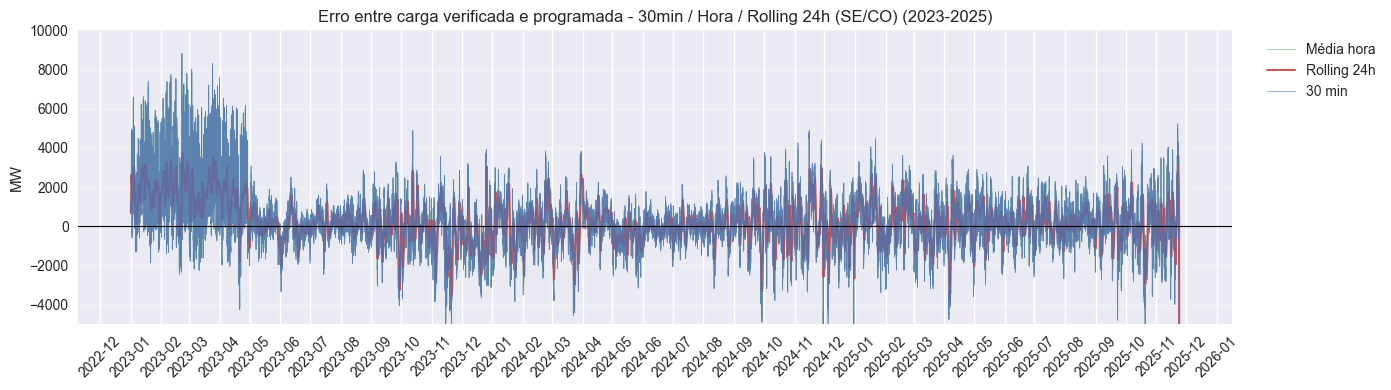

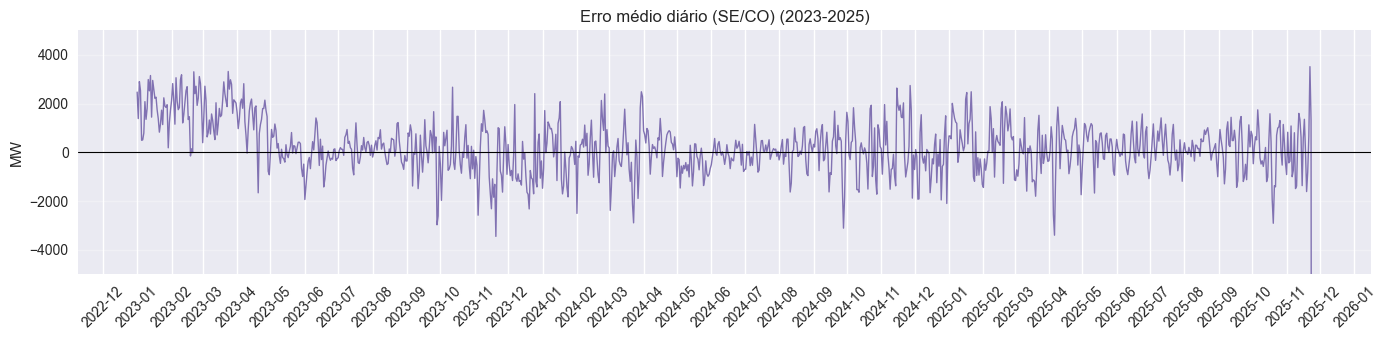

In [53]:
from matplotlib.dates import MonthLocator, DateFormatter

df = df_carga.copy()
df['din_referenciautc'] = pd.to_datetime(df['din_referenciautc'], utc=True, errors='coerce')
df = df.dropna(subset=['din_referenciautc']).sort_values('din_referenciautc').set_index('din_referenciautc')

err_30min = df['erro_prog']
err_hour = err_30min.resample('h').mean()
err_day = err_30min.resample('D').mean()
err_roll_24h = err_30min.rolling(window=48, min_periods=1).mean()  # 48 x 30min = 24h

# Plot principal: 30min (fino), hora (média) e rolling 24h (suavizada)
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(err_hour.index, err_hour, color='C1', alpha=0.5, linewidth=0.7, label='Média hora')
ax.plot(err_roll_24h.index, err_roll_24h, color='C2', alpha=0.95, linewidth=1.5, label='Rolling 24h')
ax.plot(err_30min.index, err_30min, color='C0', alpha=0.8, linewidth=0.5, label='30 min')
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel('MW')
ax.set_title('Erro entre carga verificada e programada - 30min / Hora / Rolling 24h (SE/CO) (2023-2025)')
ax.legend(title=None, bbox_to_anchor=(1.02, 1), loc='upper left')

# Formatação do eixo X por mês
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(-5000, 10000)
plt.tight_layout()
plt.show()

# Plot opcional: média diária (bom para tendências mais longas)
fig, ax = plt.subplots(figsize=(14, 3.5))
ax.plot(err_day.index, err_day, color='C3', linewidth=1)
ax.axhline(0, color='black', linewidth=0.8)
ax.set_title('Erro médio diário (SE/CO) (2023-2025)')
ax.set_ylabel('MW')
ax.set_ylim(-5000, 5000)
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()